# Data preprocessing

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.api.types import union_categoricals

### Read dataset

In [13]:
data = pd.read_csv('../data/processed_data/processed_data_2015_onward_mean.csv')

In [14]:
data.head(20)

,EventDate,Actor1CountryCode,Actor2CountryCode,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
0,2015-01-31,AFG,PAK,1.062500,0.275670,4.125000,4.125000
1,2015-01-31,AFG,USA,1.693333,-1.697247,7.933333,7.933333
2,2015-01-31,AFR,BDI,-1.000000,0.353357,5.000000,5.000000
3,2015-01-31,AFR,USA,2.800000,5.889282,10.000000,10.000000
4,2015-01-31,AFR,ZAF,-10.000000,-5.931919,4.000000,4.000000
5,2015-01-31,ARM,BGR,3.400000,2.430847,5.000000,5.000000
6,2015-01-31,AUS,ARE,-10.000000,-5.566219,3.000000,3.000000
7,2015-01-31,AUS,USA,1.000000,4.019882,5.500000,5.500000
8,2015-01-31,BFA,CIV,3.400000,-4.093567,6.000000,6.000000
9,2015-01-31,BHR,ARE,-10.000000,-13.043478,6.000000,6.000000


### Alphabetical order transformation

### Remove tuples that contain the same two countries but in different order by averaging the values from both tuples (ex. AFG - PAK and PAK - AFG)

In [15]:
data[['Actor1CountryCode', 'Actor2CountryCode']] = \
    data[['Actor1CountryCode', 'Actor2CountryCode']].apply(
        lambda x: sorted(x), axis=1, result_type='expand'
    )

In [17]:
data = data.groupby(['EventDate', 'Actor1CountryCode',	'Actor2CountryCode'])[['GoldsteinScale_Averaged',	'AvgTone_Averaged', 'NumMentions_averaged', 'NumArticles_averaged']].mean().reset_index()

In [18]:
data.head(5)

,EventDate,Actor1CountryCode,Actor2CountryCode,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
0,2015-01-31,AFG,PAK,1.827083,-0.594263,4.270833,4.270833
1,2015-01-31,AFG,USA,2.575833,-1.874094,6.758333,6.758333
2,2015-01-31,AFR,BDI,-1.000000,0.353357,5.000000,5.000000
3,2015-01-31,AFR,DJI,5.200000,-1.477833,3.000000,3.000000
4,2015-01-31,AFR,NGA,1.000000,-2.072539,6.000000,6.000000


### Familiarization

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239911 entries, 0 to 239910
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   EventDate                239911 non-null  object 
 1   Actor1CountryCode        239911 non-null  object 
 2   Actor2CountryCode        239911 non-null  object 
 3   GoldsteinScale_Averaged  239911 non-null  float64
 4   AvgTone_Averaged         239911 non-null  float64
 5   NumMentions_averaged     239911 non-null  float64
 6   NumArticles_averaged     239911 non-null  float64
dtypes: float64(4), object(3)
memory usage: 12.8+ MB


In [20]:
data.describe()

,GoldsteinScale_Averaged,AvgTone_Averaged,NumMentions_averaged,NumArticles_averaged
count,239911.000000,239911.000000,239911.000000,239911.000000
mean,1.285411,-1.009916,5.150839,5.048537
std,3.433031,3.731656,3.026468,2.871697
min,-10.000000,-23.469388,1.000000,1.000000
25%,0.000000,-3.333333,3.125000,3.050000
50%,1.700000,-1.062417,5.000000,4.872727
75%,3.400000,1.326219,6.000000,6.000000
max,10.000000,21.052632,275.000000,275.000000


In [21]:
data.shape

(239911, 7)

# Graph building

In [22]:
# extract nodes from data - the unique country codes
a1 = pd.Categorical(data['Actor1CountryCode'])
a2 = pd.Categorical(data['Actor2CountryCode'])
nodes = union_categoricals([a1, a2]).categories.to_list()
nodes

['ABW',
 'AFG',
 'AFR',
 'AGO',
 'AIA',
 'ALB',
 'AND',
 'ARE',
 'ARG',
 'ARM',
 'ASA',
 'ATG',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BHS',
 'BLR',
 'BLZ',
 'BMU',
 'BOL',
 'BRA',
 'BRB',
 'BRN',
 'BTN',
 'BWA',
 'CAF',
 'CAN',
 'CAS',
 'CAU',
 'CHE',
 'CHL',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COK',
 'COL',
 'COM',
 'CPV',
 'CRB',
 'CRI',
 'CUB',
 'CYM',
 'CYP',
 'CZE',
 'DEU',
 'DJI',
 'DMA',
 'DNK',
 'DOM',
 'DZA',
 'EAF',
 'ECU',
 'EGY',
 'ERI',
 'ESP',
 'EST',
 'ETH',
 'EUR',
 'FIN',
 'FJI',
 'FRA',
 'FSM',
 'GAB',
 'GBR',
 'GEO',
 'GHA',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRC',
 'GRD',
 'GTM',
 'GUY',
 'HKG',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IND',
 'IRL',
 'IRN',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'KNA',
 'KOR',
 'KWT',
 'LAM',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LIE',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAC',
 'MAR',
 'MCO',
 'MDA',
 'MDG',
 'MDV',


In [23]:
g = nx.MultiGraph()

In [24]:
g.nodes

NodeView(())

In [25]:
g.edges

MultiEdgeView([])

In [26]:
filtered_data = data[data.iloc[:, 0] == '2015-01-31']

for _, row in filtered_data.iterrows():
    g.add_edge(row.iloc[1], row.iloc[2], row.iloc[3])
    g.add_edge(row.iloc[1], row.iloc[2], row.iloc[4])
    g.add_edge(row.iloc[1], row.iloc[2], row.iloc[5])
    g.add_edge(row.iloc[1], row.iloc[2], row.iloc[6])


In [27]:
g.edges

MultiEdgeView([('AFG', 'PAK', 1.8270833333333334), ('AFG', 'PAK', -0.5942633517284122), ('AFG', 'PAK', 4.270833333333334), ('AFG', 'USA', 2.575833333333333), ('AFG', 'USA', -1.8740936519096871), ('AFG', 'USA', 6.758333333333333), ('PAK', 'CHN', 4.0), ('PAK', 'CHN', 0.3003003003003), ('PAK', 'CHN', 6.0), ('PAK', 'MEX', -4.4), ('PAK', 'MEX', 1.88679245283019), ('PAK', 'MEX', 10.0), ('PAK', 'SAU', -10.0), ('PAK', 'SAU', -3.89610389610389), ('PAK', 'SAU', 3.0), ('PAK', 'USA', 1.0), ('PAK', 'USA', -3.79213483146067), ('PAK', 'USA', 10.0), ('USA', 'AFR', 2.3499999999999996), ('USA', 'AFR', 5.88928150765607), ('USA', 'AFR', 10.0), ('USA', 'AUS', 1.0), ('USA', 'AUS', 4.019881541115765), ('USA', 'AUS', 5.5), ('USA', 'BGD', 0.0), ('USA', 'BGD', -6.55737704918032), ('USA', 'BGD', 6.0), ('USA', 'BLR', -5.0), ('USA', 'BLR', -6.700812535232), ('USA', 'BLR', 1.0), ('USA', 'BLZ', 0.0), ('USA', 'BLZ', -3.55029585798816), ('USA', 'BLZ', 2.5), ('USA', 'CAN', 4.0), ('USA', 'CAN', 0.708993357179355), ('USA

In [28]:
for (u,v,d) in g.edges:
    print((u,v,d))

('AFG', 'PAK', 1.8270833333333334)
('AFG', 'PAK', -0.5942633517284122)
('AFG', 'PAK', 4.270833333333334)
('AFG', 'USA', 2.575833333333333)
('AFG', 'USA', -1.8740936519096871)
('AFG', 'USA', 6.758333333333333)
('PAK', 'CHN', 4.0)
('PAK', 'CHN', 0.3003003003003)
('PAK', 'CHN', 6.0)
('PAK', 'MEX', -4.4)
('PAK', 'MEX', 1.88679245283019)
('PAK', 'MEX', 10.0)
('PAK', 'SAU', -10.0)
('PAK', 'SAU', -3.89610389610389)
('PAK', 'SAU', 3.0)
('PAK', 'USA', 1.0)
('PAK', 'USA', -3.79213483146067)
('PAK', 'USA', 10.0)
('USA', 'AFR', 2.3499999999999996)
('USA', 'AFR', 5.88928150765607)
('USA', 'AFR', 10.0)
('USA', 'AUS', 1.0)
('USA', 'AUS', 4.019881541115765)
('USA', 'AUS', 5.5)
('USA', 'BGD', 0.0)
('USA', 'BGD', -6.55737704918032)
('USA', 'BGD', 6.0)
('USA', 'BLR', -5.0)
('USA', 'BLR', -6.700812535232)
('USA', 'BLR', 1.0)
('USA', 'BLZ', 0.0)
('USA', 'BLZ', -3.55029585798816)
('USA', 'BLZ', 2.5)
('USA', 'CAN', 4.0)
('USA', 'CAN', 0.708993357179355)
('USA', 'CAN', 5.5)
('USA', 'CHE', 7.4)
('USA', 'CHE', 

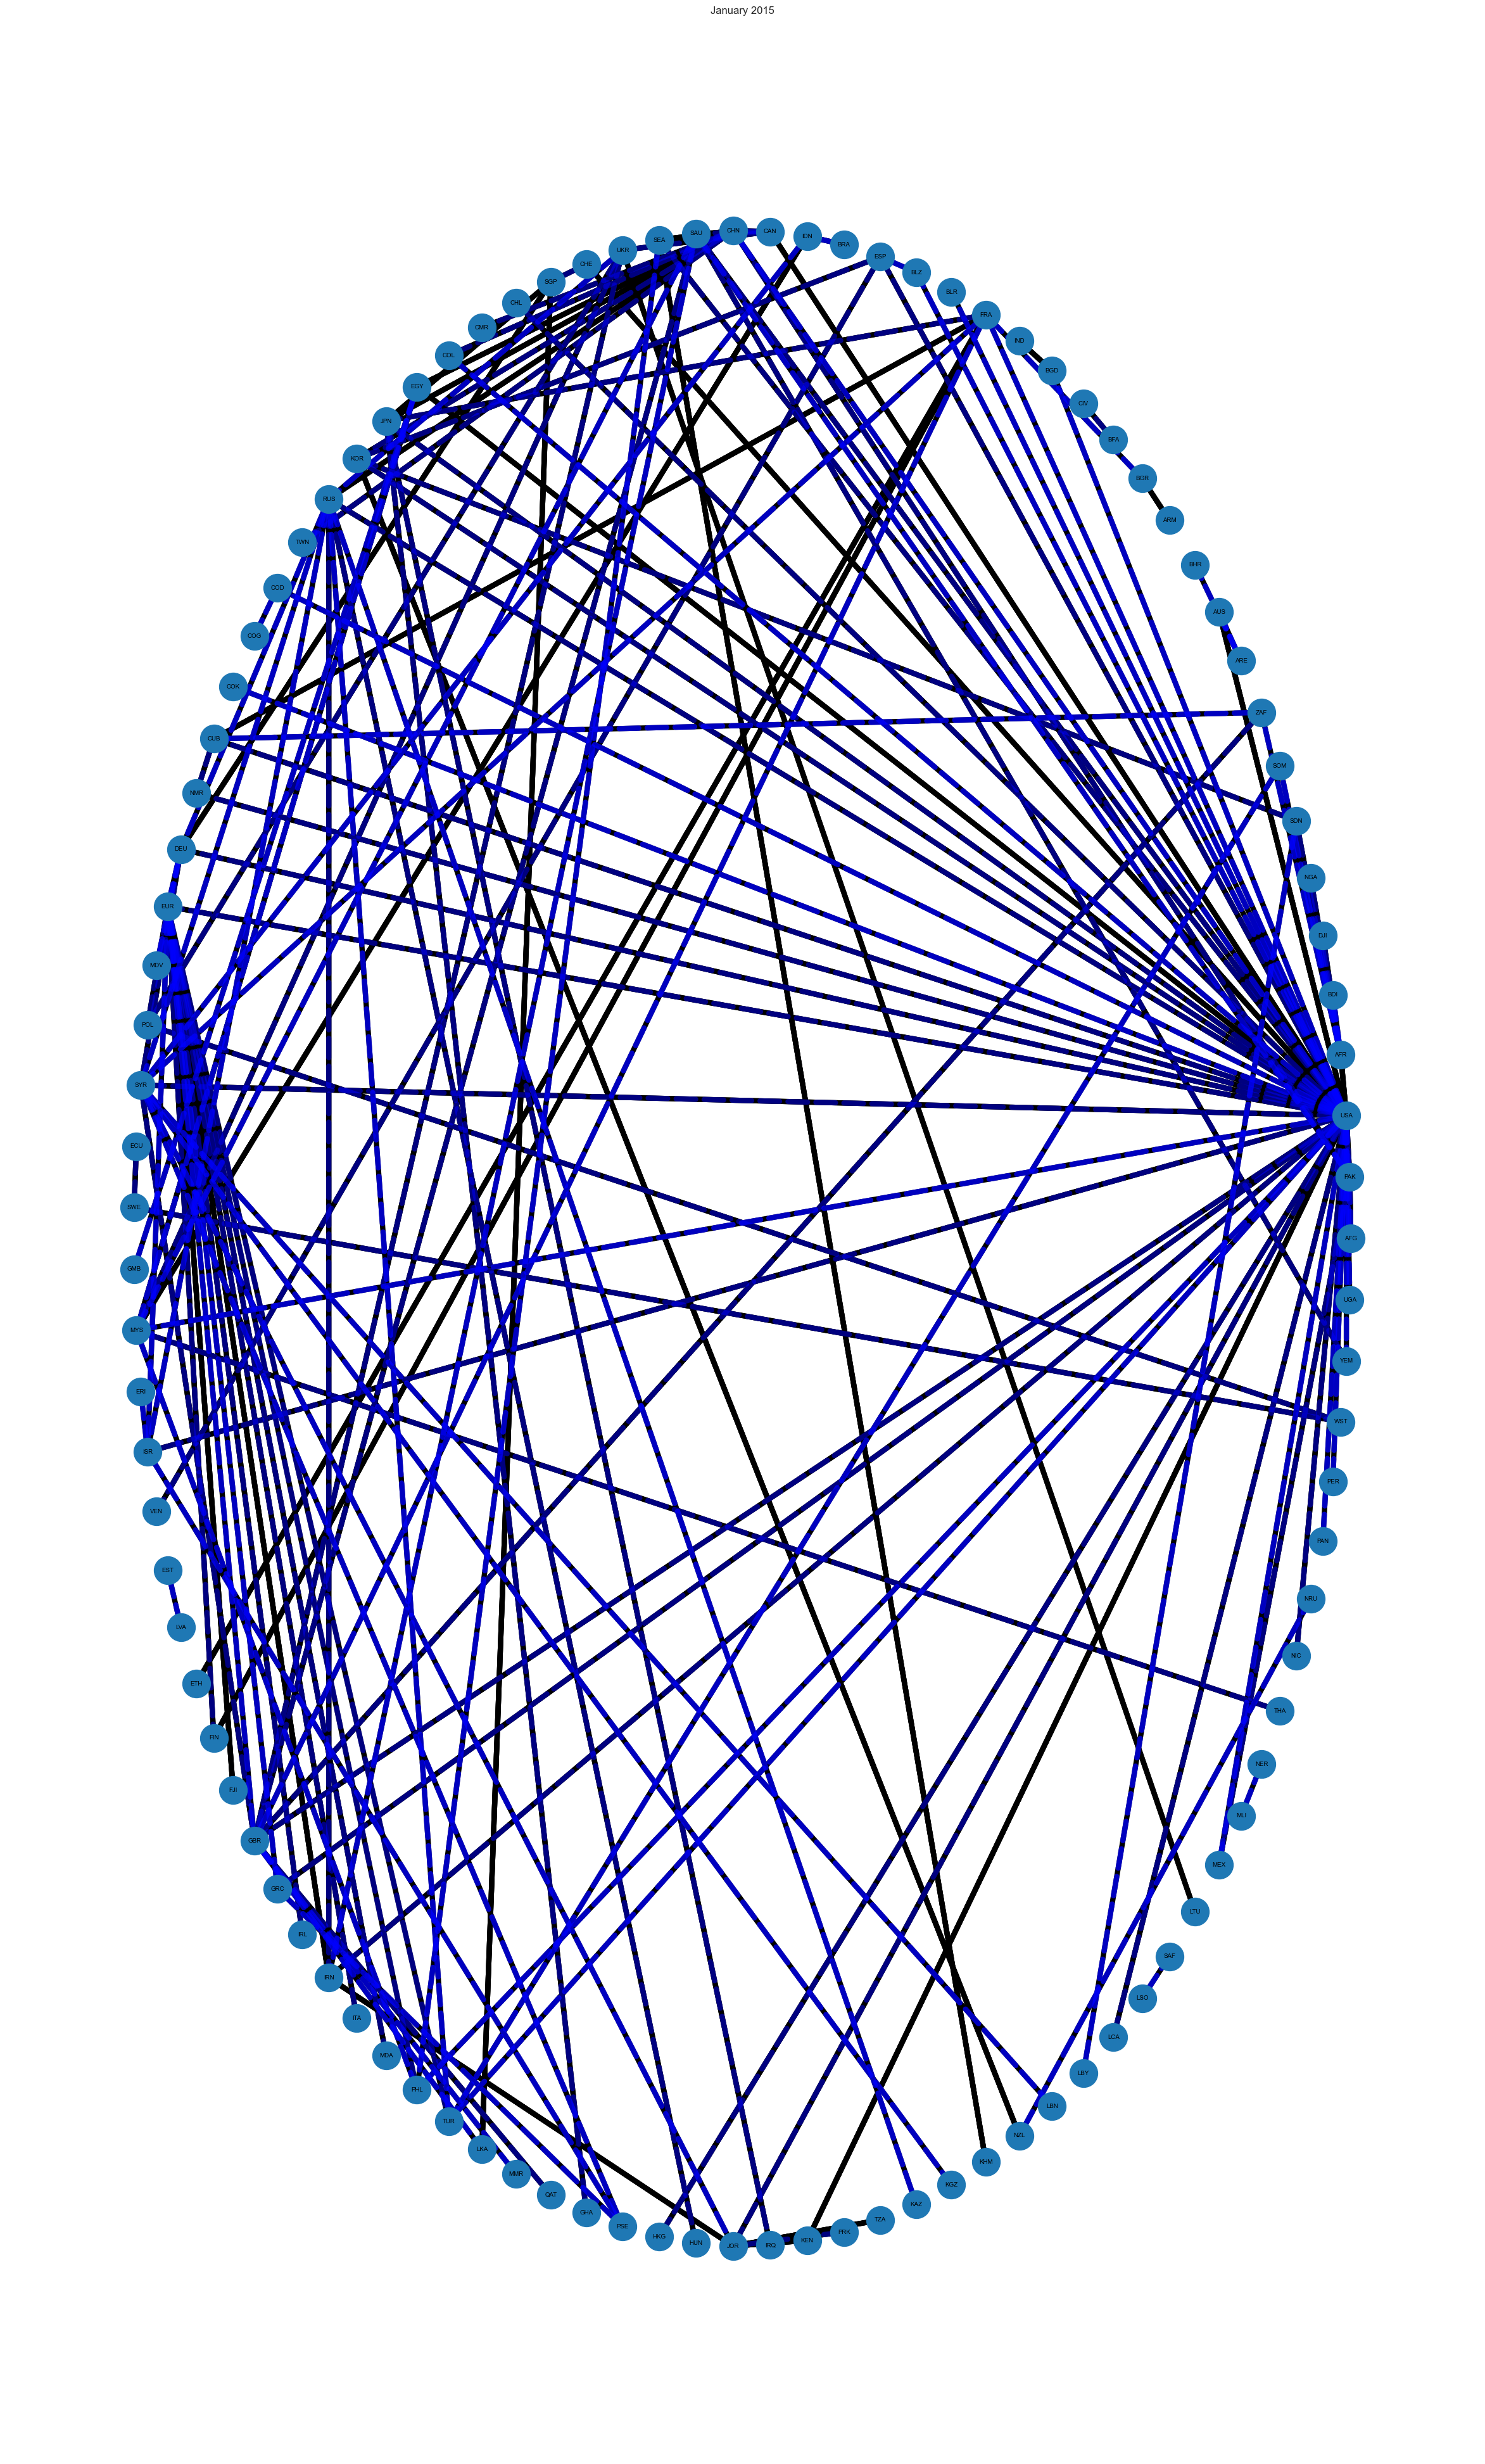

In [29]:
elarge=[(u,v) for (u,v,d) in g.edges if d >0.5]
esmall=[(u,v) for (u,v,d) in g.edges if d <=0.5]

plt.figure(figsize=(30, 50))
pos=nx.circular_layout(g) # positions for all nodes

# nodes
nx.draw_networkx_nodes(g,pos,node_size=1000)

# edges
nx.draw_networkx_edges(g,pos,edgelist=elarge,
                    width=6)
nx.draw_networkx_edges(g,pos,edgelist=esmall,
                    width=6,alpha=0.5,edge_color='b',style='dashed')

# labels
nx.draw_networkx_labels(g,pos,font_size=7,font_family='sans-serif')

plt.axis('off')
plt.title('January 2015')
plt.savefig("weighted_graph.png") # save as png
plt.show() # display